In [1]:
# https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_agentic_rag.ipynb

from io import BytesIO
import pypdfium2 as pdfium
import backoff
import asyncio
import json
import os
import base64
from PIL import Image
import operator

from typing import Annotated, Sequence, TypedDict, Literal

from openai import OpenAIError
from openai import AsyncOpenAI, OpenAI

from langchain_openai import ChatOpenAI
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.messages import AnyMessage, BaseMessage, HumanMessage, SystemMessage
from langchain.tools.retriever import create_retriever_tool
from langchain_community.vectorstores import FAISS

from langgraph.graph.message import add_messages
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode


from IPython.display import Image, display
from pydantic import BaseModel, Field

In [2]:
MODEL = "gpt-4o-2024-08-06"
baseurl = ""
apikey = ""

clienta = AsyncOpenAI(api_key=apikey,  base_url=baseurl)
os.environ["OPENAI_API_BASE"] = baseurl
os.environ["OPENAI_API_KEY"] = apikey

In [3]:
@backoff.on_exception(backoff.expo, OpenAIError)
async def parse_page_with_gpt(base64_image: str) -> str:
    messages=[
        {
            "role": "system",
            "content": """
            
            You are a helpful assistant that extracts information from images.
            
            """
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Extract information from image into text"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}",
                        "detail": "auto"
                    },
                },
            ],
        }
    ]
    response = await clienta.chat.completions.create(
        model=MODEL,
        messages=messages,
        temperature=0,
        max_tokens=4096,
    )
    return response.choices[0].message.content or ""

In [4]:
async def document_analysis(filename: str) -> str:
    """
    Document Understanding

    Args:
        filename: pdf filename str
    """

    pdf = pdfium.PdfDocument(filename)
    images = []
    for i in range(len(pdf)):
        page = pdf[i]
        image = page.render(scale=8).to_pil()
        buffered = BytesIO()
        image.save(buffered, format="JPEG")
        img_byte = buffered.getvalue()
        img_base64 = base64.b64encode(img_byte).decode("utf-8")
        images.append(img_base64)

    text_of_pages = await asyncio.gather(*[parse_page_with_gpt(image) for image in images])
    
    results = []

    extracted_texts = [doc for doc in text_of_pages]
    # Clean each string in the list and append to json_results
    for text in extracted_texts:
        results.append(text)
        
    return results

In [5]:
docs_list = await document_analysis("workato.pdf")

In [6]:
docs_list

['**Behind the AI Hype**\n\nThe 2024 State of LLMs in Business Processes\n\nLogos: Workato with UserEvidence',
 'Contents\n\n01 Overview  \n02 Top Findings  \n03 Chapter 1: What’s Driving AI Adoption  \n05 Chapter 2: Activating LLMs in Business Processes  \n10 Chapter 3: The Outcomes of Generative AI in Business Processes  \n15 Chapter 4: Governance of AI in Business Processes  \n18 Chapter 5: The Role of People in a World of Autonomous AI and Agents  \n23 Chapter 6: AI Agents & The Future of Business Processes  \n28 Conclusion  \n29 Methodology & Demographics  \n32 About UserEvidence  \n\nResearch conducted and verified by UserEvidence',
 '**Overview**\n\nMarket sentiment about generative AI has entered a new era. **Early hype is fading.** Business leaders have a clearer view of its strengths and challenges.\n\nMajor press, such as the Wall Street Journal, The Economist, and others have wondered if the AI hype over-promised and under-delivered. But very few have considered a key value

In [7]:
import uuid

output_file_path = f"{uuid.uuid4()}.txt"

with open(output_file_path, 'w') as json_file:
    json.dump(docs_list, json_file, indent=2)

print(f"data has been written to {output_file_path}")

data has been written to ee273450-7e77-42b3-8281-d453980ace5c.txt


In [8]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader(output_file_path)
data = loader.load()
data

[Document(metadata={'source': 'ee273450-7e77-42b3-8281-d453980ace5c.txt'}, page_content='[\n  "**Behind the AI Hype**\\n\\nThe 2024 State of LLMs in Business Processes\\n\\nLogos: Workato with UserEvidence",\n  "Contents\\n\\n01 Overview  \\n02 Top Findings  \\n03 Chapter 1: What\\u2019s Driving AI Adoption  \\n05 Chapter 2: Activating LLMs in Business Processes  \\n10 Chapter 3: The Outcomes of Generative AI in Business Processes  \\n15 Chapter 4: Governance of AI in Business Processes  \\n18 Chapter 5: The Role of People in a World of Autonomous AI and Agents  \\n23 Chapter 6: AI Agents & The Future of Business Processes  \\n28 Conclusion  \\n29 Methodology & Demographics  \\n32 About UserEvidence  \\n\\nResearch conducted and verified by UserEvidence",\n  "**Overview**\\n\\nMarket sentiment about generative AI has entered a new era. **Early hype is fading.** Business leaders have a clearer view of its strengths and challenges.\\n\\nMajor press, such as the Wall Street Journal, The E

In [9]:
# Check if the file exists
if os.path.exists(output_file_path):
    
    # Delete the file
    os.remove(output_file_path)
    print(f"File {output_file_path} deleted successfully.")
else:
    print("File does not exist.")

File ee273450-7e77-42b3-8281-d453980ace5c.txt deleted successfully.


In [10]:
from langchain_text_splitters import CharacterTextSplitter
text_splitter = CharacterTextSplitter(
    chunk_size=1000, chunk_overlap=500
)
doc_splits = text_splitter.split_documents(data)

In [11]:
embedding_model = OpenAIEmbeddings()
faiss_db = FAISS.from_documents(doc_splits, embedding_model) 
retriever = faiss_db.as_retriever(search_type="similarity", search_kwargs={"k": 4})

In [12]:
retriever_tool = create_retriever_tool(
    retriever,
    "document_understanding",
    "Retrieve and provide insights on document content analysis and knowledge extraction",
)
tools = [retriever_tool]

In [13]:
class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [14]:
### Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)
    

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) then grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    print("question: ", question)
    print("context: ", docs)
    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [15]:
### Nodes
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4o", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-4o", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    print("context: ", docs)
    print("question: ", question)
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like


********************Prompt[rlm/rag-prompt]********************


/Users/ferry.djaja/anaconda3/lib/python3.11/site-packages/langsmith/client.py:322: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


/Users/ferry.djaja/anaconda3/lib/python3.11/site-packages/langsmith/client.py:5301: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  prompt = loads(json.dumps(prompt_object.manifest))


In [16]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()


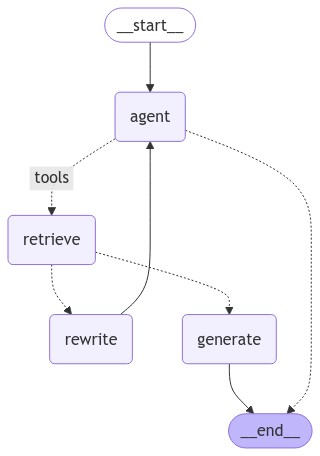

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [29]:
import pprint

inputs = {
    "messages": [
        ("user", """
        in figure 4.2 - what is the percentage of Important ?
        """),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_wEGiL0zmaICmVmyWBTLQlvlm', 'function': {'arguments': '{"query":"figure 4.2 - percentage of Important"}', 'name': 'document_understanding'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_e375328146'}, id='run-cd3f9f47-df23-4708-8c60-9f5aaea8cc3a-0', tool_calls=[{'name': 'document_understanding', 'args': {'query': 'figure 4.2 - percentage of Important'}, 'id': 'call_wEGiL0zmaICmVmyWBTLQlvlm', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
question:  
        in figure 4.2 - what is the percentage of Important ?
        
context:  [
  "**Behind the AI Hype**\n\nThe 2024 State of LLMs in Business Processes\n\nLogos: Workato with UserEvidence",
  "Contents\n\n01 Overview  \n02 Top Findings  \n03 Chapter 1: What\u2019s Driving AI Adoption  \n05 Chapt

/Users/ferry.djaja/anaconda3/lib/python3.11/site-packages/langsmith/client.py:322: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


context:  [
  "**Behind the AI Hype**\n\nThe 2024 State of LLMs in Business Processes\n\nLogos: Workato with UserEvidence",
  "Contents\n\n01 Overview  \n02 Top Findings  \n03 Chapter 1: What\u2019s Driving AI Adoption  \n05 Chapter 2: Activating LLMs in Business Processes  \n10 Chapter 3: The Outcomes of Generative AI in Business Processes  \n15 Chapter 4: Governance of AI in Business Processes  \n18 Chapter 5: The Role of People in a World of Autonomous AI and Agents  \n23 Chapter 6: AI Agents & The Future of Business Processes  \n28 Conclusion  \n29 Methodology & Demographics  \n32 About UserEvidence  \n\nResearch conducted and verified by UserEvidence",
  "**Overview**\n\nMarket sentiment about generative AI has entered a new era. **Early hype is fading.** Business leaders have a clearer view of its strengths and challenges.\n\nMajor press, such as the Wall Street Journal, The Economist, and others have wondered if the AI hype over-promised and under-delivered. But very few have co

In [30]:
import pprint

inputs = {
    "messages": [
        ("user", """
        in figure 3.1 - what is the percentage of customer satisfaction ?
        """),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_jGekeZgfN4lnnoTfTCRt49EX', 'function': {'arguments': '{"query":"figure 3.1 percentage of customer satisfaction"}', 'name': 'document_understanding'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_a2ff031fb5'}, id='run-8c2ed030-857a-424b-be1b-8fdb3fd83561-0', tool_calls=[{'name': 'document_understanding', 'args': {'query': 'figure 3.1 percentage of customer satisfaction'}, 'id': 'call_jGekeZgfN4lnnoTfTCRt49EX', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
question:  
        in figure 3.1 - what is the percentage of customer satisfaction ?
        
context:  [
  "**Behind the AI Hype**\n\nThe 2024 State of LLMs in Business Processes\n\nLogos: Workato with UserEvidence",
  "Contents\n\n01 Overview  \n02 Top Findings  \n03 Chapter 1: What\u2019s

/Users/ferry.djaja/anaconda3/lib/python3.11/site-packages/langsmith/client.py:322: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


context:  [
  "**Behind the AI Hype**\n\nThe 2024 State of LLMs in Business Processes\n\nLogos: Workato with UserEvidence",
  "Contents\n\n01 Overview  \n02 Top Findings  \n03 Chapter 1: What\u2019s Driving AI Adoption  \n05 Chapter 2: Activating LLMs in Business Processes  \n10 Chapter 3: The Outcomes of Generative AI in Business Processes  \n15 Chapter 4: Governance of AI in Business Processes  \n18 Chapter 5: The Role of People in a World of Autonomous AI and Agents  \n23 Chapter 6: AI Agents & The Future of Business Processes  \n28 Conclusion  \n29 Methodology & Demographics  \n32 About UserEvidence  \n\nResearch conducted and verified by UserEvidence",
  "**Overview**\n\nMarket sentiment about generative AI has entered a new era. **Early hype is fading.** Business leaders have a clearer view of its strengths and challenges.\n\nMajor press, such as the Wall Street Journal, The Economist, and others have wondered if the AI hype over-promised and under-delivered. But very few have co

In [ ]:
import pprint

inputs = {
    "messages": [
        ("user", """
        in figure 3.1 - what is the percentage of customer satisfaction ?
        """),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")